<a href="https://colab.research.google.com/github/alizmarossy/FAKT_ML/blob/main/hetedikminiprojekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Zajszűrés képeken

Guide: https://keras.io/examples/vision/autoencoder/

##Packagek importálása

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


##Modellkörnyezet megalkotása

In [13]:
#Adatok normalizálása és átformázása
def preprocess(array):
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

#Random zaj hozzáadása a képekhez
def noise(array):
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

#Random képek kiválasztása, amiken az eredmények látszódnak
def display(array1, array2):
    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

##Adatok előkészítése

11501568/11490434 [==============================] - 0s 0us/step


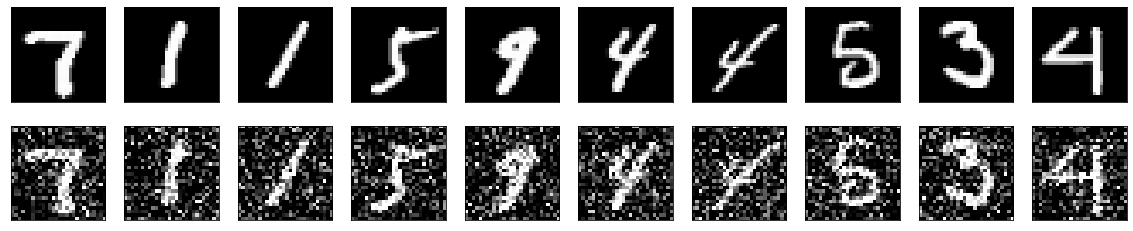

In [14]:
#Tanuló- és tesztadatbázis létrehozása
(train_data, _), (test_data, _) = mnist.load_data()

#Adatok normalizálása és előkészítése mindkét adatbázison
train_data = preprocess(train_data)
test_data = preprocess(test_data)

#Egy másolat készítése az adatbázisokról, amikhez hozzáadjuk a random zajt
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

display(train_data, noisy_train_data)

##Autoencoder betanítása Functional API-jal

In [15]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248  

In [16]:
#Az autoencoder tanítása a tesztadatbázison, inputként és célként is a tesztadatbázist használva
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 19s 18ms/step - loss: 0.1264 - val_loss: 0.0725
Epoch 2/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0710 - val_loss: 0.0690
Epoch 3/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0689 - val_loss: 0.0677
Epoch 4/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0678 - val_loss: 0.0669
Epoch 5/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0670 - val_loss: 0.0663
Epoch 6/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0665 - val_loss: 0.0658
Epoch 7/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0661 - val_loss: 0.0655
Epoch 8/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0657 - val_loss: 0.0652
Epoch 9/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0654 - val_loss: 0.0649
Epoch 10/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0652 - val_l

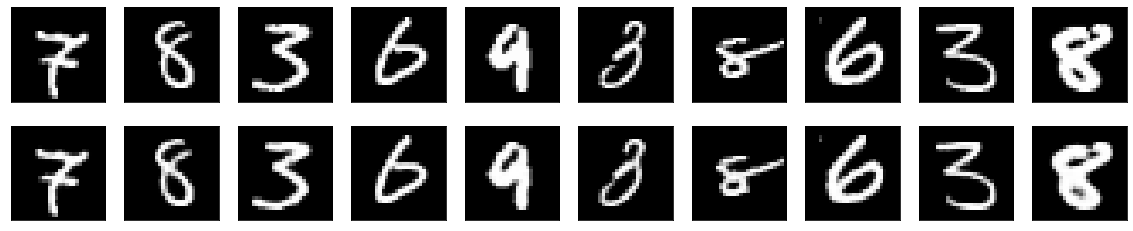

In [17]:
#szinte ugyanolyanok
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

##A modell eredményességének vizsgálata

In [18]:
#Most a zajos képeket adjuk be neki inputként és megtanítjuk, hogyan kell eltűntetni a zajt róluk.
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 8s 17ms/step - loss: 0.1014 - val_loss: 0.0935
Epoch 2/100
469/469 [==============================] - 8s 16ms/step - loss: 0.0930 - val_loss: 0.0912
Epoch 3/100
469/469 [==============================] - 8s 16ms/step - loss: 0.0913 - val_loss: 0.0900
Epoch 4/100
469/469 [==============================] - 8s 16ms/step - loss: 0.0902 - val_loss: 0.0891
Epoch 5/100
469/469 [==============================] - 8s 16ms/step - loss: 0.0894 - val_loss: 0.0884
Epoch 6/100
469/469 [==============================] - 8s 16ms/step - loss: 0.0888 - val_loss: 0.0880
Epoch 7/100
469/469 [==============================] - 8s 16ms/step - loss: 0.0883 - val_loss: 0.0876
Epoch 8/100
469/469 [==============================] - 8s 16ms/step - loss: 0.0879 - val_loss: 0.0872
Epoch 9/100
469/469 [==============================] - 8s 16ms/step - loss: 0.0876 - val_loss: 0.0869
Epoch 10/100
469/469 [==============================] - 7s 16ms/step - loss: 0.087

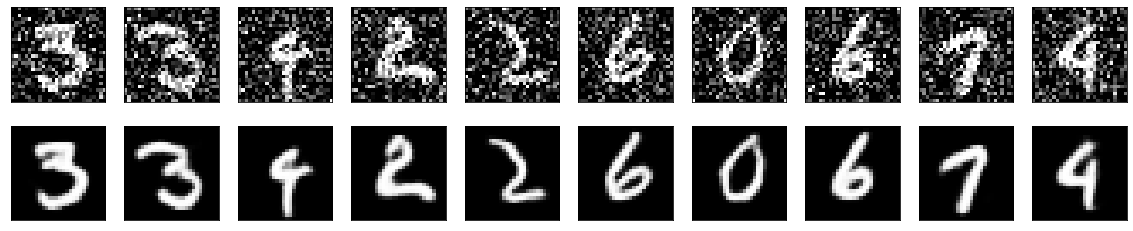

In [19]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

A modell szépen eltűntette a zajt a képekről.

##Második próba

 Nagyobb zaj hozzáadása és megnézzük, erre mit produkál.

In [20]:
#Adatok normalizálása és átformázása
def preprocess(array):
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

#Nagyobb random zaj hozzáadása a képekhez
def noise(array):
    noise_factor = 0.8
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

#Random képek kiválasztása, amiken az eredmények látszódnak
def display(array1, array2):
    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

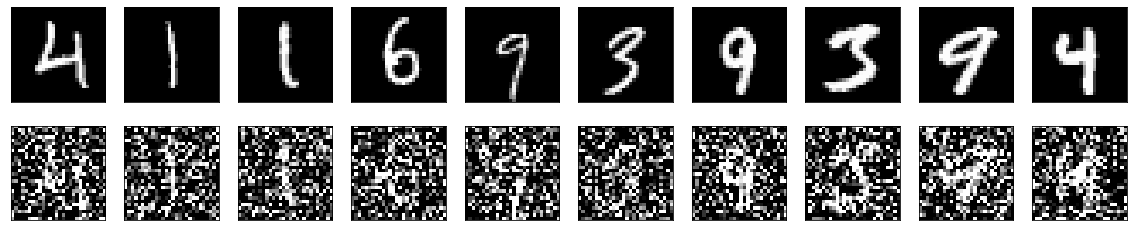

In [21]:
#Tanuló- és tesztadatbázis létrehozása
(train_data, _), (test_data, _) = mnist.load_data()

#Adatok normalizálása és előkészítése mindkét adatbázison
train_data = preprocess(train_data)
test_data = preprocess(test_data)

#Egy másolat készítése az adatbázisokról, amikhez hozzáadjuk a random zajt
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

display(train_data, noisy_train_data)

Azért így már nem sok látszik

In [22]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 32)       9248

In [23]:
#Az autoencoder tanítása a tesztadatbázison, inputként és célként is a tesztadatbázist használva
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 8s 16ms/step - loss: 0.1333 - val_loss: 0.0731
Epoch 2/50
469/469 [==============================] - 7s 16ms/step - loss: 0.0717 - val_loss: 0.0696
Epoch 3/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0694 - val_loss: 0.0681
Epoch 4/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0682 - val_loss: 0.0672
Epoch 5/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0673 - val_loss: 0.0666
Epoch 6/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0668 - val_loss: 0.0661
Epoch 7/50
469/469 [==============================] - 7s 16ms/step - loss: 0.0663 - val_loss: 0.0656
Epoch 8/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0660 - val_loss: 0.0653
Epoch 9/50
469/469 [==============================] - 7s 16ms/step - loss: 0.0657 - val_loss: 0.0652
Epoch 10/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0654 - val_lo

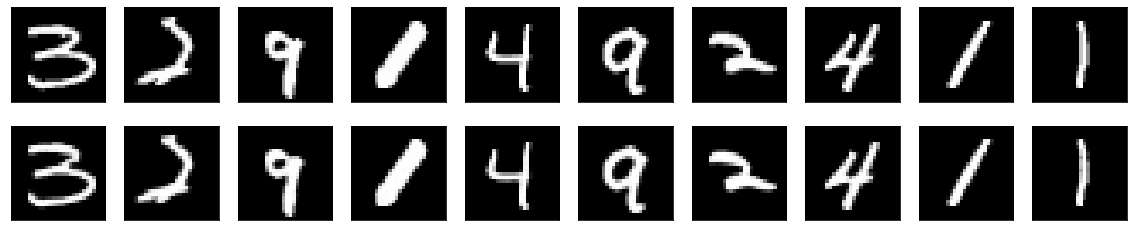

In [24]:
#szinte ugyanolyanok
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [25]:
#Most a zajos képeket adjuk be neki inputként és megtanítjuk, hogyan kell eltűntetni a zajt róluk.
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 8s 17ms/step - loss: 0.1718 - val_loss: 0.1583
Epoch 2/100
469/469 [==============================] - 8s 16ms/step - loss: 0.1574 - val_loss: 0.1542
Epoch 3/100
469/469 [==============================] - 8s 16ms/step - loss: 0.1540 - val_loss: 0.1516
Epoch 4/100
469/469 [==============================] - 8s 16ms/step - loss: 0.1516 - val_loss: 0.1495
Epoch 5/100
469/469 [==============================] - 8s 16ms/step - loss: 0.1500 - val_loss: 0.1482
Epoch 6/100
469/469 [==============================] - 8s 16ms/step - loss: 0.1487 - val_loss: 0.1470
Epoch 7/100
469/469 [==============================] - 8s 16ms/step - loss: 0.1477 - val_loss: 0.1464
Epoch 8/100
469/469 [==============================] - 8s 16ms/step - loss: 0.1469 - val_loss: 0.1453
Epoch 9/100
469/469 [==============================] - 8s 16ms/step - loss: 0.1461 - val_loss: 0.1451
Epoch 10/100
469/469 [==============================] - 8s 17ms/step - loss: 0.145

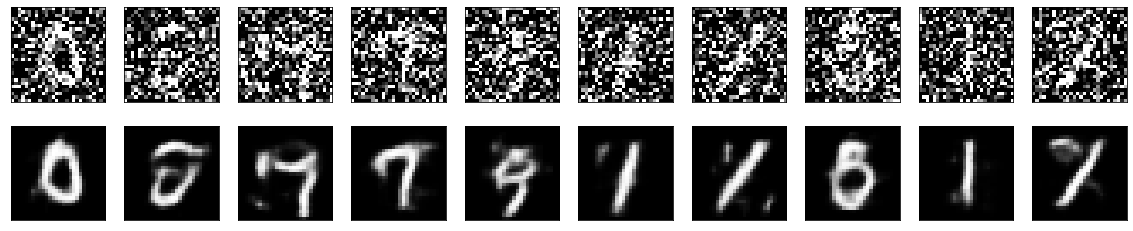

In [26]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

Így azért nem mindegyik olvasható, de többet lát, mint én.